### Next spike timing
The point of this notebook is to briefly access whether there is a correlation between the standard deviation of spike firing and the distance to the compared to cell.

The standard deviation will be calculated by looking at each transient in cell X and checking when the next transient fires in cell Y and noting the time.

In [121]:
import numpy as np
import xarray as xr
import pandas as pd
from core.backend import open_minian
from scipy.ndimage.measurements import center_of_mass
import dask.array as darr
from matplotlib import pyplot as plt

C:\Users\Michal Lange\AppData\Local\Temp\ipykernel_438812\2985590817.py:5: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.measurements import center_of_mass


In [169]:
# load in xarray
data = open_minian(r"C:\Users\Michal Lange\Documents\Cell_Clustering_Tool\data\05.2023_Tenth_group-AA058_D1-2023_05_05-11_02_42-Miniscope_2-S1\minian")
E = data['E']
verified = E.verified.values.astype(int)
E = E[verified==1]
A = data['A']

In [170]:
# Iterate over all cells and get the starting time for each event
cells_to_event_start = {}
units_ids = E.unit_id.values

for cell in units_ids:
    cell_data = E.sel(unit_id=cell).values

    indices = cell_data.nonzero()
    split_indices = np.split(indices[0], np.where(np.diff(indices[0]) != 1)[0]+1)
    split_indices = [indices_group[0] for indices_group in split_indices]
    cells_to_event_start[cell] = split_indices

In [171]:
cells_to_event_start

{2: [53,
  8935,
  9162,
  9849,
  9908,
  10618,
  10761,
  10843,
  10926,
  11041,
  11281,
  14625,
  15902,
  16192,
  16557,
  17150,
  17215,
  21468,
  21831,
  22293,
  22376,
  22599,
  23657,
  23844,
  24404],
 4: [390,
  2777,
  4788,
  6840,
  7382,
  9009,
  10216,
  11514,
  12268,
  12847,
  13786,
  14177,
  16563,
  17188,
  18072,
  21483,
  22376,
  25104,
  25650,
  27126],
 5: [60,
  398,
  983,
  1189,
  1386,
  1769,
  2457,
  2897,
  4351,
  4956,
  5930,
  8666,
  9844,
  11046,
  11269,
  12731,
  12799,
  13287,
  14496,
  14766,
  15039,
  15154,
  15877,
  16159,
  17067,
  17218,
  17294,
  17393,
  17982,
  18012,
  18561,
  18845,
  20054,
  20444,
  20772,
  21095,
  21708,
  22914,
  23473,
  23551,
  23615,
  24749,
  25768,
  26206,
  27071,
  27229],
 11: [314,
  426,
  2123,
  2936,
  3484,
  4574,
  4886,
  5914,
  6240,
  8819,
  8978,
  9094,
  9648,
  10321,
  11044,
  12306,
  12848,
  12947,
  13169,
  13611,
  14012,
  15759,
  16749,
  16

In [172]:
def compare_cells(cell1, cell2):
    cell1_events = cells_to_event_start[cell1]
    cell2_events = cells_to_event_start[cell2].copy()

    distances = []
    for start1 in cell1_events:
        indices_to_remove = []
        for i, start2 in enumerate(cell2_events):
            if start1 <= start2:
                distances.append(start2 - start1)
                break
            else:
                indices_to_remove.append(i)
        if indices_to_remove:
            # remove all indices in indices_to_remove
            indices_to_remove.reverse()
            for index in indices_to_remove:
                cell2_events.pop(index)
    
    return distances

def check_cofiring(cell1, cell2, slack=50):
    cell1_events = cells_to_event_start[cell1]
    cell2_events = cells_to_event_start[cell2]

    num_cofiring = 0

    for start1 in cell1_events:
        for start2 in cell2_events:
            if abs(start1 - start2) <= slack:
                num_cofiring += 1

    return num_cofiring


    


def centroid(A: xr.DataArray, verbose=False) -> pd.DataFrame:
    def rel_cent(im):
        im_nan = np.isnan(im)
        if im_nan.all():
            return np.array([np.nan, np.nan])
        if im_nan.any():
            im = np.nan_to_num(im)
        cent = np.array(center_of_mass(im))
        return cent / im.shape

    gu_rel_cent = darr.gufunc(
        rel_cent,
        signature="(h,w)->(d)",
        output_dtypes=float,
        output_sizes=dict(d=2),
        vectorize=True,
    )
    cents = xr.apply_ufunc(
        gu_rel_cent,
        A.chunk(dict(height=-1, width=-1)),
        input_core_dims=[["height", "width"]],
        output_core_dims=[["dim"]],
        dask="allowed",
    ).assign_coords(dim=["height", "width"])
    if verbose:
        print("computing centroids")
        with ProgressBar():
            cents = cents.compute()
    cents_df = (
        cents.rename("cents")
        .to_series()
        .dropna()
        .unstack("dim")
        .rename_axis(None, axis="columns")
        .reset_index()
    )
    h_rg = (A.coords["height"].min().values, A.coords["height"].max().values)
    w_rg = (A.coords["width"].min().values, A.coords["width"].max().values)
    cents_df["height"] = cents_df["height"] * (h_rg[1] - h_rg[0]) + h_rg[0]
    cents_df["width"] = cents_df["width"] * (w_rg[1] - w_rg[0]) + w_rg[0]
    return cents_df

centroids = centroid(A)

def calculate_distance(cell1, cell2):
    cell1_row = centroids[centroids['unit_id'] == cell1]
    cell1_center = (cell1_row['height'].values[0], cell1_row['width'].values[0])
    cell2_row = centroids[centroids['unit_id'] == cell2]
    cell2_center = (cell2_row['height'].values[0], cell2_row['width'].values[0])

    return np.sqrt((cell1_center[0] - cell2_center[0])**2 + (cell1_center[1] - cell2_center[1])**2)

In [141]:
print(units_ids)

[  2   7  18  21  34  37  40  44  50  53  76  79 122 123 127 163 169 187
 197 214]


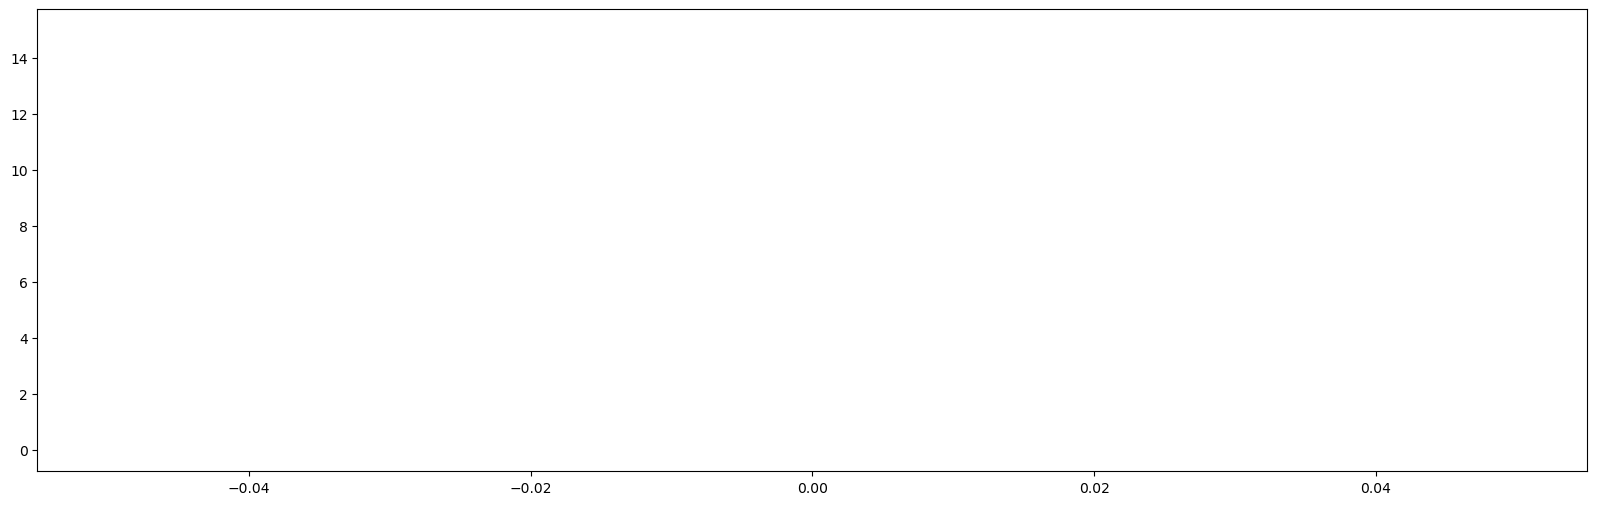

In [173]:
time_results = []
distances = []



for cell in units_ids:
    for other_cell in units_ids:
        if cell == other_cell:
            continue
        times = check_cofiring(cell, other_cell, slack=30)
        time_results.append((cell, other_cell, times))

        distance = calculate_distance(cell, other_cell)
        distances.append((cell, other_cell, distance))
    
# plot all the distances
plt.figure(figsize=(20,6))
for result in time_results:
    plt.plot(result[2])

plt.show()

In [167]:
len(distances)

380

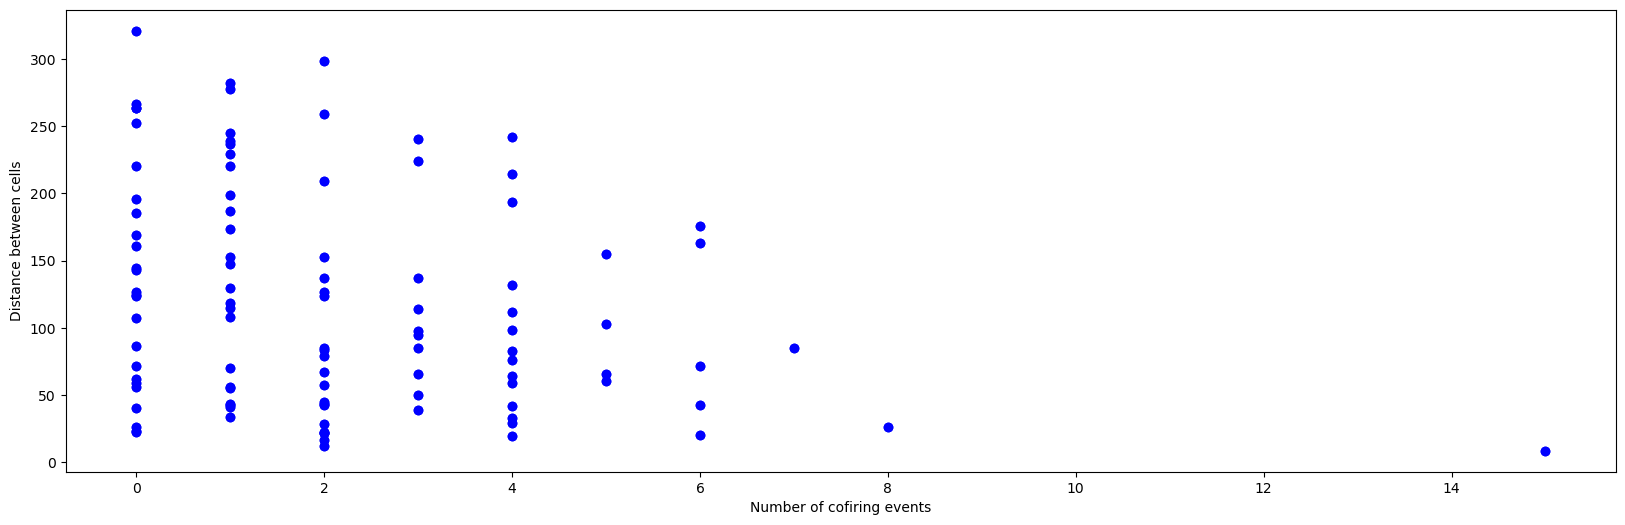

In [178]:
# Put the results into a dataframe
df = pd.DataFrame(time_results, columns=['cell1', 'cell2', 'cofiring'])
# Insert the distance but match cell1 and cell2
df['distance'] = [distance[2] for distance in distances]
# Create a new column for the stds
#df['std'] = [np.std(times) for times in df['times']]
#df['median'] = [np.median(times) for times in df['times']]
# Sort by the stds
df = df.sort_values(by='cofiring')
# Plot the stds to distances
plt.figure(figsize=(20,6))
# Label the axes
plt.xlabel('Number of cofiring events')
plt.ylabel('Distance between cells')
plt.plot(df['cofiring'], df['distance'], 'bo')

In [180]:
# Save df to csv
df.to_csv('cofiring1.csv')